In [4]:
import json
import re
import os
import glob
import re
import konlpy
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from collections import Counter
import numpy as np
import pyLDAvis.gensim
import pandas as pd

In [5]:
okt = konlpy.tag.Okt()
kkma =  konlpy.tag.Kkma()

### 데이터 불러오기 및 **백성** 이 포함된 날짜 남기기

In [6]:
def data_clean(keyword):
    text_list=[]
    with open('순종.txt', 'r', encoding='utf-8') as f:
        text = f.read()
        text_list = text_list + text.split("=====")
        text_list =[text for text in text_list if keyword in text]
        clean_text = []
        for line in range(len(text_list)):
            clean_text.append(re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','',text_list[line]))
    return clean_text

In [7]:
data_list = data_clean('국민')
len(data_list)

10

In [8]:
#data_list[0]

### 불용어 제거 후, **명사,형용사** 만 남기기

In [51]:
stopword = ['전하','임금','사람','여러','나라','로써','또한','지금','어찌','모두','우리','순종실록','순종','번째기사',
            '하니','입니다','어떻겠습니까','기사','없습니다','없으니','있는','있습니다','감히','더욱','때문','있을','있다','에셔','이상','서로'
           ]

In [52]:
def postag(data_list):
    word_temp =[]
    for i in range(len(data_list)):
        word = okt.pos(''.join(data_list[i]))
        word_temp2=[]
        for j in word:
            if len(j[0])>1 and j[0] not in stopword:
                if j[1] in ['Noun', 'Adjective']: #명사, 형용사
                    word_temp2.append(j[0])
        word_temp.append(word_temp2)
    return word_temp

In [53]:
word_list =  postag(data_list)

### 단어들을 가지고 LDA모델링

In [54]:
def topic(word):
    dictionary = corpora.Dictionary(word)
    corpus = [dictionary.doc2bow(text) for text in word]
    NUM_TOPICS = 15
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
    topics = ldamodel.print_topics(num_words=4)
    topic_list = []
    for topic in topics:
        topic_list.append(topic)
    return topic_list

In [55]:
topic(word_list)

[(0, '0.001*"우리나라" + 0.001*"한국" + 0.001*"일본" + 0.001*"정부"'),
 (1, '0.001*"한국" + 0.001*"국민" + 0.001*"조약" + 0.001*"일본"'),
 (2, '0.001*"한국" + 0.001*"우리나라" + 0.001*"국민" + 0.001*"조약"'),
 (3, '0.001*"한국" + 0.001*"청국" + 0.001*"일본" + 0.001*"우리나라"'),
 (4, '0.017*"일본" + 0.013*"김봉기" + 0.013*"피고" + 0.013*"정부"'),
 (5, '0.001*"우리나라" + 0.001*"폐하" + 0.001*"자기" + 0.001*"일본"'),
 (6, '0.007*"성질" + 0.007*"포기" + 0.007*"정성스러운" + 0.007*"있어"'),
 (7, '0.016*"나이" + 0.016*"적십자사" + 0.012*"일본" + 0.012*"한국"'),
 (8, '0.023*"우리나라" + 0.016*"자기" + 0.012*"부강" + 0.010*"독립"'),
 (9, '0.043*"한국" + 0.033*"국민" + 0.028*"정부" + 0.025*"청국"'),
 (10, '0.001*"일본" + 0.001*"폐하" + 0.001*"한국" + 0.001*"백성"'),
 (11, '0.021*"일본" + 0.016*"폐하" + 0.012*"백성" + 0.011*"한국"'),
 (12, '0.001*"일본" + 0.001*"한국" + 0.001*"폐하" + 0.001*"백성"'),
 (13, '0.001*"우리나라" + 0.001*"조약" + 0.001*"한국" + 0.001*"국민"'),
 (14, '0.042*"어업" + 0.034*"한국" + 0.025*"국민" + 0.019*"협정"')]

### 토픽모델링 시각화

In [56]:
def view_lda(word):
    pyLDAvis.enable_notebook()
    dictionary = corpora.Dictionary(word)
    corpus = [dictionary.doc2bow(text) for text in word]
    NUM_TOPICS = 15
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
    vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
    return pyLDAvis.display(vis)

In [57]:
view_lda(word_list)

### 각 주제가 가장 많은 비중을 차지하는 리뷰

### 백성키워드의 연관규칙

In [58]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

In [59]:
def apriori_result(word_list):
    te = TransactionEncoder()
    te_result = te.fit(word_list).transform(word_list)
    df = pd.DataFrame(te_result,columns=te.columns_)
    itemset = apriori(df, use_colnames=True)
    itemset['length']= itemset['itemsets'].apply(lambda x: len(x))
    itemset=itemset[itemset['length'] == 2]
    return itemset

In [60]:
apriori_result(word_list)

,support,itemsets,length
16,0.5,"(각각, 관리)",2
17,0.5,"(각각, 국민)",2
18,0.5,"(각각, 대한)",2
19,0.5,"(양력, 각각)",2
20,0.6,"(관리, 국민)",2
...,...,...,...
80,0.5,"(정부, 일본국)",2
81,0.5,"(한국, 일본국)",2
82,0.5,"(체결, 정부)",2
83,0.6,"(한국, 정부)",2


In [61]:
itemset = apriori_result(word_list)

### 네트워크 그래프
> 참고사이트 : http://blog.daum.net/geoscience/1408

In [62]:
import networkx as nx
import matplotlib.pyplot as plt

# 한글깨짐방지코드
import matplotlib
from matplotlib import font_manager, rc
import platform
if platform.system()=="Windows":
    font_name=font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus']=False

import warnings
warnings.filterwarnings("ignore")

In [63]:
def network_g(itemset):
    G = nx.Graph()
    ar = (itemset['itemsets']);G.add_edges_from(ar)
    pr = nx.pagerank(G)
    nsize = np.array([v for v in pr.values()])
    nsize = 2000 *(nsize-min(nsize))/(max(nsize)-min(nsize))
#     pos = nx.planar_layout(G)
    pos = nx.shell_layout(G)
    plt.figure(figsize=(10,10)); plt.axis('off')
    return nx.draw_networkx(G,font_size=16,
                pos=pos, node_color=list(pr.values()),node_size=nsize,font_family=font_name,
                alpha=0.7,edge_color='.5',cmap=plt.cm.RdBu_r)

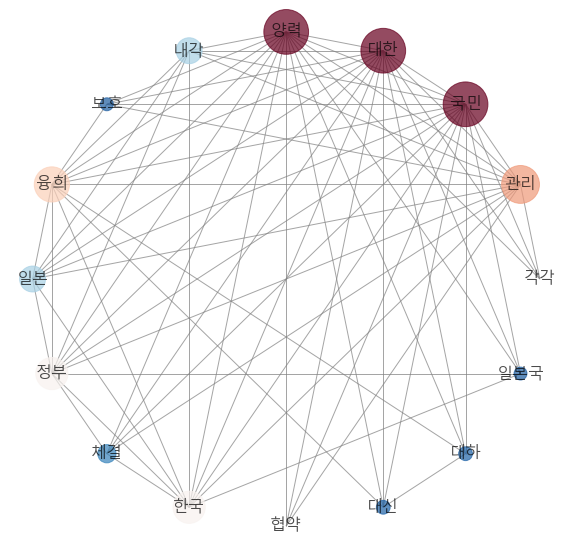

In [64]:
network_g(itemset)